In [ ]:
import pandas as pd
import spacy
from collections import Counter

# CONFIGURATION
INPUT = "/home/ensai/Cours/PFE/Topic-modeling-with-NLP/data/makeorg_biodiversite.xlsx" # Path to the dataset
OUTPUT = "output.xlsx"
TEXT_COL = "Proposition"
NEW_COL = "Tokens_lemmas"
MODEL = "fr_core_news_lg" 

# READ DATA
df = pd.read_excel(INPUT)

if TEXT_COL not in df.columns:
    raise ValueError(f"Column '{TEXT_COL}' not found. Available: {list(df.columns)}")

# Remove leading "Il faut …"
df[TEXT_COL] = df[TEXT_COL].str.replace(r'^\s*Il faut\s+', '', case=False, regex=True)

# LOAD MODEL
nlp = spacy.load(MODEL)

# Stopwords personnalisés (plus sélectifs)
CUSTOM_STOPWORDS = {
    'être', 'avoir', 'faire', 'pouvoir', 'devoir', 'vouloir',
    'aller', 'mettre', 'prendre', 'dire', 'savoir', 'voir',
    'celui', 'celle', 'ceux', 'celles', 'ceci', 'cela',
    'le', 'la', 'les', 'un', 'une', 'des', 'du', 'de',
    'ce', 'cette', 'ces', 'mon', 'ma', 'mes', 'ton', 'ta', 'tes',
    'son', 'sa', 'ses', 'notre', 'nos', 'votre', 'vos', 'leur', 'leurs',
    'je', 'tu', 'il', 'elle', 'nous', 'vous', 'ils', 'elles',
    'me', 'te', 'se', 'lui', 'leur', 'en', 'y',
    'qui', 'que', 'quoi', 'dont', 'où',
    'et', 'ou', 'mais', 'donc', 'car', 'ni', 'or',
    'à', 'dans', 'par', 'pour', 'avec', 'sans', 'sous', 'sur', 'vers',
    'très', 'plus', 'moins', 'bien', 'mal', 'beaucoup', 'peu', 'trop',
    'aussi', 'encore', 'toujours', 'jamais', 'déjà', 'souvent', 'pas'
}

def doc_to_lemmas(doc):
    """
    Extrait les lemmes pertinents pour l'analyse sémantique
    Focus sur: NOUN, VERB, ADJ, ADV principalement
    """
    lemmas = []
    
    for tok in doc:
        # Skip ponctuation et espaces
        if tok.is_punct or tok.is_space:
            continue
        
        # Skip nombres
        if tok.like_num or tok.is_digit:
            continue
        
        # Skip tokens non-alphabétiques (sauf si composés avec tiret)
        if not tok.is_alpha and '-' not in tok.text:
            continue
        
        # Skip si trop court (souvent du bruit)
        if len(tok.text) < 3:
            continue
        
        # Filtrage par POS (Part-of-Speech)
        # Gardez les mots porteurs de sens
        if tok.pos_ not in ['NOUN', 'VERB', 'ADJ', 'PROPN', 'ADV']:
            continue
        
        # Lemmatisation
        lemma = tok.lemma_.lower().strip()
        
        # Skip stopwords personnalisés
        if lemma in CUSTOM_STOPWORDS:
            continue
        
        # Skip si le lemma est vide ou trop court après nettoyage
        if len(lemma) < 3:
            continue
        
        lemmas.append(lemma)
    
    return lemmas

# PROCESS TEXTS
print("Traitement des textes...")
texts = df[TEXT_COL].astype(str).fillna("").tolist()

# Utilisez parser pour avoir les POS tags corrects
docs = nlp.pipe(texts, disable=["ner"])  # Gardez le parser !

df[NEW_COL] = [doc_to_lemmas(doc) for doc in docs]

# Filtrer les propositions vides
df = df[df[NEW_COL].map(len) > 0].reset_index(drop=True)

print(f"{len(df)} propositions traitées")
print(f"\nExemples de lemmatisation:")
print(df[[TEXT_COL, NEW_COL]].head(10))

# Statistiques sur le vocabulaire
all_lemmas = [lemma for lemmas in df[NEW_COL] for lemma in lemmas]
vocab_size = len(set(all_lemmas))
avg_length = sum(len(lemmas) for lemmas in df[NEW_COL]) / len(df)

print(f"\n Statistiques:")
print(f"  - Vocabulaire total: {vocab_size} lemmes uniques")
print(f"  - Longueur moyenne: {avg_length:.1f} lemmes/proposition")
print(f"  - Total tokens: {len(all_lemmas)}")

# Top lemmes les plus fréquents
lemma_counts = Counter(all_lemmas)
print(f"\n Top 20 lemmes:")
for lemma, count in lemma_counts.most_common(20):
    print(f"  {lemma}: {count}")

🔄 Traitement des textes...
✅ 5554 propositions traitées

📊 Exemples de lemmatisation:
                                         Proposition  \
0  favoriser le reboisement urbain afin de baisse...   
1  stopper l’érosion des haies (-23 500km par an)...   
2  stopper l'importation de produits agricoles tr...   
3  réintégrer les arbres et les haies dans l’agri...   
4  empêcher l'importation de produits agricoles q...   
5  replanter des haies pour éviter l'érosion des ...   
6  punir sévèrement ceux qui déversent des déchet...   
7  replanter des haies autour des champs afin de ...   
8  préserver, restaurer, maintenir en bon état éc...   
9  soutenir une agriculture protectrice du vivant...   

                                       Tokens_lemmas  
0  [favoriser, reboisement, urbain, afin, baisser...  
1  [stopper, érosion, haie, puissant, levier, tra...  
2  [stopper, importation, produit, agricole, trai...  
3  [réintégrer, arbre, haie, agriculture, produir...  
4  [empêcher, importat

In [ ]:
import random
from gensim.models import Word2Vec
from gensim.test.utils import datapath


SEED = 42
random.seed(SEED)


sentences = df[NEW_COL].tolist()  # données d'entraînement

# === Hyperparamètres à tester : intervalle 0.0100–0.0150 ===
learning_rates = [round(random.uniform(0.0100, 0.0150), 4) for _ in range(20)]
print("Learning rates testés :", learning_rates)

best_score = float('-inf')
best_model = None
best_alpha = None

# === Random Search ===
for alpha in learning_rates:
    print(f"\n Test du learning rate = {alpha}")

    model = Word2Vec(
        sentences=sentences,
        vector_size=128,
        window=7,
        min_count=2,
        sg=0,            # CBOW: 0 & SKIP-GRAm:1
        workers=4,
        hs=1,
        negative=0,
        epochs=30,
        alpha=alpha,
        min_alpha=0.0001,
        seed=SEED        # Seed pour Gensim
    )

    # === ÉVALUATION ===
    try:
        wordsim_file = datapath("wordsim353.tsv")
        score, _ = model.wv.evaluate_word_pairs(wordsim_file)
        print(f"Score validation = {score:.4f}")
    except:
        # fallback interne si WordSim353 indisponible
        score = model.wv.get_normed_vectors().mean()
        print(f"Score interne = {score:.4f}")

    # === Sélection du meilleur modèle ===
    if score > best_score:
        best_score = score
        best_model = model
        best_alpha = alpha
        print("Nouveau meilleur modèle enregistré.")

print("\n========================")
print(f"Meilleur learning rate = {best_alpha}")
print(f"Score = {best_score:.4f}")
print("========================")

Learning rates testés : [0.0132, 0.0101, 0.0114, 0.0111, 0.0137, 0.0134, 0.0145, 0.0104, 0.0121, 0.0101, 0.0111, 0.0125, 0.0101, 0.011, 0.0132, 0.0127, 0.0111, 0.0129, 0.014, 0.01]

 Test du learning rate = 0.0132
Score interne = -0.0012
Nouveau meilleur modèle enregistré.

 Test du learning rate = 0.0101
Score interne = -0.0019

 Test du learning rate = 0.0114
Score interne = -0.0009
Nouveau meilleur modèle enregistré.

 Test du learning rate = 0.0111
Score interne = -0.0014

 Test du learning rate = 0.0137
Score interne = -0.0008
Nouveau meilleur modèle enregistré.

 Test du learning rate = 0.0134
Score interne = -0.0010

 Test du learning rate = 0.0145
Score interne = -0.0007
Nouveau meilleur modèle enregistré.

 Test du learning rate = 0.0104
Score interne = -0.0012

 Test du learning rate = 0.0121
Score interne = -0.0008

 Test du learning rate = 0.0101
Score interne = -0.0010

 Test du learning rate = 0.0111
Score interne = 0.0003
Nouveau meilleur modèle enregistré.

 Test du lea

In [ ]:
# # TRAIN CBOW MODEL
# from gensim.models import Word2Vec

# sentences = df[NEW_COL].tolist()

# print("\n Entraînement du modèle CBOW...")
# model = Word2Vec(
#     sentences=sentences,
#     vector_size=128,
#     window=7,
#     min_count=2, 
#     sg=1,  # CBOW
#     workers=4,
#     hs=1, 
#     negative=0,  
#     epochs=30, 
#     alpha=0.01,  # Learning rate
#     min_alpha=0.0001
# )

# print(f"Modèle entraîné: {len(model.wv)} mots dans le vocabulaire")


🤖 Entraînement du modèle CBOW...
✅ Modèle entraîné: 3243 mots dans le vocabulaire


In [17]:
# Test du modèle

model = best_model
print("\n🔍 Test de similarité:")
test_words = ['biodiversité', 'nature', 'protéger', 'espèce']
for word in test_words:
    if word in model.wv:
        similar = model.wv.most_similar(word, topn=5)
        print(f"\n'{word}' est similaire à:")
        for w, score in similar:
            print(f"  - {w}: {score:.3f}")


🔍 Test de similarité:

'biodiversité' est similaire à:
  - ludique: 0.470
  - écosystème: 0.470
  - importance: 0.455
  - travers: 0.449
  - pédagogie: 0.431

'nature' est similaire à:
  - enfant: 0.529
  - âge: 0.490
  - éduquer: 0.483
  - observer: 0.474
  - jeune: 0.459

'protéger' est similaire à:
  - marin: 0.549
  - menacer: 0.547
  - marine: 0.500
  - aire: 0.499
  - restant: 0.456

'espèce' est similaire à:
  - menacer: 0.644
  - réintroduire: 0.605
  - envahissant: 0.529
  - bison: 0.502
  - exotique: 0.482



 Création des vecteurs de propositions (128D)...
Shape des embeddings: (5554, 128)

 Recherche du nombre optimal de clusters (dans l'espace 128D)...
  k=5: silhouette=0.080
  k=6: silhouette=0.067
  k=7: silhouette=0.069
  k=8: silhouette=0.069
  k=9: silhouette=0.071
  k=10: silhouette=0.074
  k=11: silhouette=0.075
  k=12: silhouette=0.079
  k=13: silhouette=0.079
  k=14: silhouette=0.080
  k=15: silhouette=0.076
  k=16: silhouette=0.081
  k=17: silhouette=0.080
  k=18: silhouette=0.080
  k=19: silhouette=0.079
  k=20: silhouette=0.077


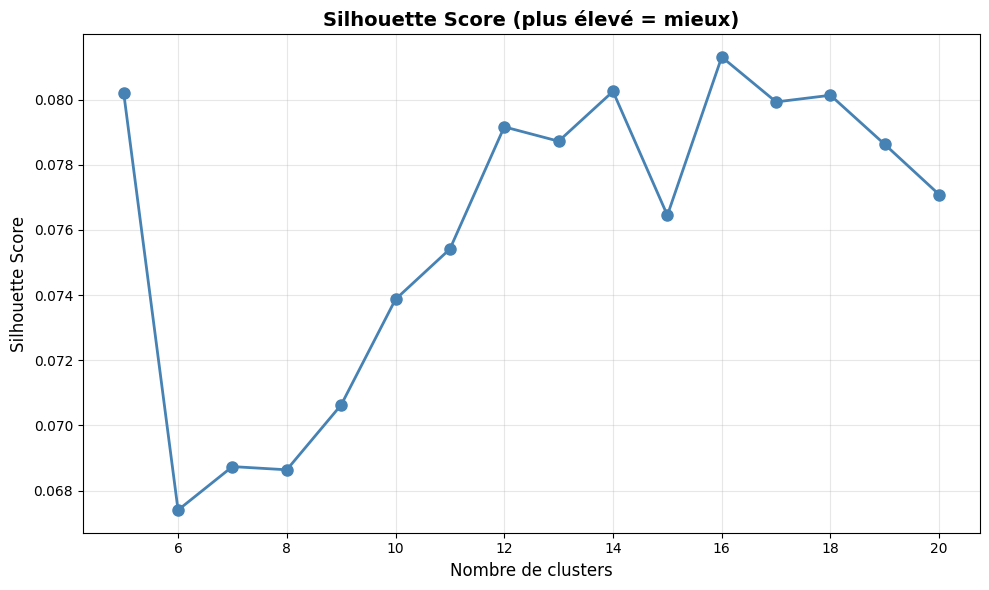


 Meilleur k selon Silhouette: 16
   Score: 0.081

 Clustering final avec k=16 (dans l'espace 128D)
 Clustering effectué dans l'espace 128D


In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter

def proposition_to_vector(lemmas, model):
    """
    Moyenne des vecteurs de mots (avec gestion des mots absents)
    """
    vectors = []
    for lemma in lemmas:
        if lemma in model.wv:
            vectors.append(model.wv[lemma])
    
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    
    return np.mean(vectors, axis=0)

# Créer les vecteurs de propositions dans l'espace 128D
print("\n Création des vecteurs de propositions (128D)...")
X = np.array([proposition_to_vector(lemmas, model) for lemmas in sentences])

print(f"Shape des embeddings: {X.shape}")  # Devrait être (n_propositions, 128)

# ========================================
# CLUSTERING DANS L'ESPACE 128D
# ========================================

print("\n Recherche du nombre optimal de clusters (dans l'espace 128D)...")
silhouette_scores = []
K_range = range(5, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X)  # Clustering dans 128D !
    
    sil_score = silhouette_score(X, labels)
    silhouette_scores.append(sil_score)
    
    print(f"  k={k}: silhouette={sil_score:.3f}")

# Plot de la silhouette uniquement
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Nombre de clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score (plus élevé = mieux)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('silhouette_score.png', dpi=300)
plt.show()

# Choisir le meilleur k
best_k_silhouette = K_range[np.argmax(silhouette_scores)]

print(f"\n Meilleur k selon Silhouette: {best_k_silhouette}")
print(f"   Score: {max(silhouette_scores):.3f}")

# Utiliser le k choisi
best_k = best_k_silhouette
print(f"\n Clustering final avec k={best_k} (dans l'espace 128D)")

# Clustering final dans l'espace 128D
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)
df['cluster'] = kmeans_final.fit_predict(X)  # Clustering dans 128D !

print(f" Clustering effectué dans l'espace {X.shape[1]}D")

In [19]:
import umap


# ========================================
# RÉDUCTION À 2D POUR VISUALISATION UNIQUEMENT
# ========================================

print("\n Réduction dimensionnelle UMAP pour visualisation (128D → 2D)...")
reducer = umap.UMAP(
    n_components=2, 
    random_state=42, 
    n_neighbors=15, 
    min_dist=0.1,
    metric='cosine'  # Cosine similarity pour les embeddings
)
embedding_2d = reducer.fit_transform(X)  # Réduction de 128D à 2D

print(f"Shape après UMAP: {embedding_2d.shape}")  # Devrait être (n_propositions, 2)




 Réduction dimensionnelle UMAP pour visualisation (128D → 2D)...


/home/ensai/Cours/PFE/Topic-modeling-with-NLP/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape après UMAP: (5554, 2)


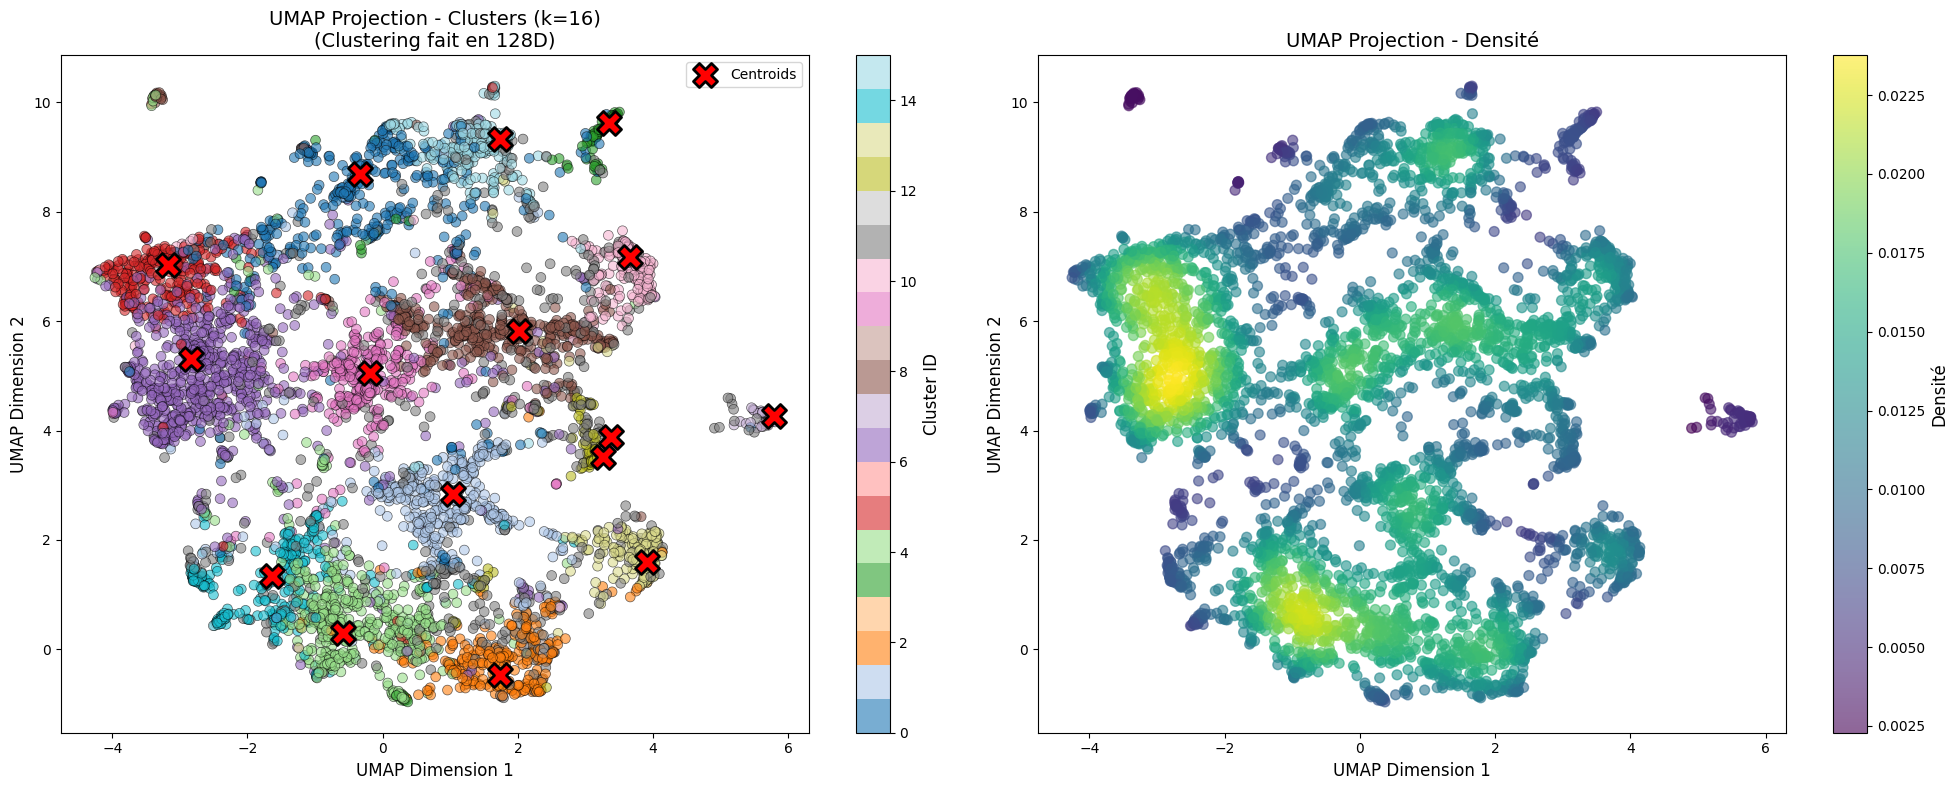

In [20]:
# ========================================
# VISUALISATION
# ========================================

# Plot 1: Scatter plot avec clusters
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Subplot 1: Coloration par cluster
scatter1 = axes[0].scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=df['cluster'], 
    cmap='tab20', 
    alpha=0.6, 
    s=50,
    edgecolors='black',
    linewidth=0.5
)
axes[0].set_title(f'UMAP Projection - Clusters (k={best_k})\n(Clustering fait en 128D)', fontsize=14)
axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster ID', fontsize=12)

# Ajouter les centroids projetés en 2D
centroids_128d = kmeans_final.cluster_centers_  # Centroids dans l'espace 128D
centroids_2d = reducer.transform(centroids_128d)  # Projeter les centroids en 2D
axes[0].scatter(
    centroids_2d[:, 0], 
    centroids_2d[:, 1], 
    c='red', 
    marker='X', 
    s=300, 
    edgecolors='black', 
    linewidth=2,
    label='Centroids'
)
axes[0].legend(fontsize=10)

# Subplot 2: Densité
from scipy.stats import gaussian_kde
xy = embedding_2d.T
z = gaussian_kde(xy)(xy)
scatter2 = axes[1].scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=z, 
    cmap='viridis', 
    alpha=0.6, 
    s=50
)
axes[1].set_title('UMAP Projection - Densité', fontsize=14)
axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Densité', fontsize=12)

plt.tight_layout()
plt.savefig('clusters_umap_full.png', dpi=300, bbox_inches='tight')
plt.show()



In [21]:
# ========================================
# ANALYSE DES CLUSTERS
# ========================================

print("\n" + "="*80)
print(" ANALYSE DÉTAILLÉE DES CLUSTERS")
print("="*80)

cluster_stats = []

for cluster_id in sorted(df['cluster'].unique()):
    cluster_docs = df[df['cluster'] == cluster_id]
    
    # Récupérer tous les lemmes du cluster
    all_cluster_lemmas = [lemma for lemmas in cluster_docs[NEW_COL] for lemma in lemmas]
    lemma_counts = Counter(all_cluster_lemmas)
    top_lemmas = lemma_counts.most_common(15)
    
    # Calculer la cohésion intra-cluster (distance moyenne au centroid)
    cluster_vectors = X[df['cluster'] == cluster_id]
    centroid = kmeans_final.cluster_centers_[cluster_id]
    avg_distance = np.mean([np.linalg.norm(v - centroid) for v in cluster_vectors])
    
    print(f"\n{'='*80}")
    print(f"🔹 CLUSTER {cluster_id} - {len(cluster_docs)} propositions ({len(cluster_docs)/len(df)*100:.1f}%)")
    print(f"{'='*80}")
    print(f" Cohésion intra-cluster: {avg_distance:.3f} (plus bas = plus cohérent)")
    print(f"\n Top 15 mots-clés:")
    for i, (word, count) in enumerate(top_lemmas, 1):
        print(f"   {i:2d}. {word:20s} ({count:3d} occurrences)")
    
    print(f"\n Exemples de propositions:")
    for idx, (_, row) in enumerate(cluster_docs.head(5).iterrows(), 1):
        text = row[TEXT_COL][:150]
        print(f"   {idx}. {text}{'...' if len(row[TEXT_COL]) > 150 else ''}")
    
    cluster_stats.append({
        'cluster': cluster_id,
        'size': len(cluster_docs),
        'cohesion': avg_distance,
        'top_words': ', '.join([w for w, c in top_lemmas[:5]])
    })

# Résumé global
print(f"\n{'='*80}")
print("RÉSUMÉ GLOBAL")
print(f"{'='*80}")

stats_df = pd.DataFrame(cluster_stats)
print(stats_df.to_string(index=False))

print(f"\n Cluster le plus cohérent: {stats_df.loc[stats_df['cohesion'].idxmin(), 'cluster']}")
print(f" Cluster le plus large: {stats_df.loc[stats_df['size'].idxmax(), 'cluster']}")



 ANALYSE DÉTAILLÉE DES CLUSTERS

🔹 CLUSTER 0 - 465 propositions (8.4%)
 Cohésion intra-cluster: 1.057 (plus bas = plus cohérent)

 Top 15 mots-clés:
    1. animal               (143 occurrences)
    2. espèce               (128 occurrences)
    3. sauvage              ( 64 occurrences)
    4. protéger             ( 51 occurrences)
    5. faune                ( 48 occurrences)
    6. nature               ( 45 occurrences)
    7. interdire            ( 45 occurrences)
    8. biodiversité         ( 44 occurrences)
    9. pas                  ( 43 occurrences)
   10. tout                 ( 42 occurrences)
   11. chasse               ( 42 occurrences)
   12. arrêter              ( 42 occurrences)
   13. loup                 ( 36 occurrences)
   14. nuisible             ( 31 occurrences)
   15. humain               ( 30 occurrences)

 Exemples de propositions:
   1. accentuer l’éveil à la nature dans les petites classes, notamment via l’apprentissage des espèces, de la faune et de la flore
